In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmf import pmf
from lda import lda_model

Load dataset

In [2]:
anime_df = pd.read_csv('data/anime.csv')
anime_df = anime_df.rename(columns={'rating': 'avg_rating'})
rating_df = pd.read_csv('data/rating.csv')

Sample a few data points to make it easier for computation

In [3]:
rating_df = rating_df.sample(n=100_000, random_state=42)

Data for pmf

In [4]:
rating_df = rating_df[rating_df['rating'] != -1]
combined_df = pd.merge(anime_df, rating_df, on='anime_id', how='inner')

uniq_users = combined_df['user_id'].unique().tolist()
uniq_animes = combined_df['anime_id'].unique().tolist()

n_users = len(uniq_users)
n_animes = len(uniq_animes)

df_copy = combined_df.copy()
train_set = df_copy.sample(frac=0.75, random_state=0)
test_set = df_copy.drop(train_set.index)

Data for lda

In [5]:
anime_df = anime_df.rename(columns={'genre': 'description'})
used_anime_ids = set(train_set['anime_id']).union(set(test_set['anime_id']))
used_user_ids = set(train_set['user_id']).union(set(test_set['user_id']))

anime_filtered = anime_df[anime_df['anime_id'].isin(used_anime_ids) & anime_df['description'].notna()]
rating_for_lda = rating_df[
    (rating_df['anime_id'].isin(anime_filtered['anime_id'])) &
    (rating_df['user_id'].isin(used_user_ids))
]
lda_df = pd.merge(anime_filtered[['anime_id', 'description']], rating_for_lda, on='anime_id', how='inner')

lda_copy = lda_df.copy()
lda_train_set = lda_copy.sample(frac=0.75, random_state=0)
lda_test_set = lda_copy.drop(lda_train_set.index)

In [6]:
pmf_model = pmf(n_users=n_users, n_animes=n_animes, lambda_U=5, lambda_V=5, uniq_users=uniq_users, uniq_animes=uniq_animes, n_dimesions=5)

In [7]:
log_ps, rmse_train, rmse_test, mae_train, mae_test = pmf_model.train(train_set=train_set, test_set=test_set,n_epochs=20)

Log p a-posteriori at iteration 1 : -41196.17098237992 , RMSE train: 1.1133064348181028 , RMSE test: 1.3960963269462754 , MAE train: 0.863775749423689 , MAE test: 1.0809396494861354
Log p a-posteriori at iteration 10 : -39419.08389585722 , RMSE train: 0.7691725171334867 , RMSE test: 1.4446104414435856 , MAE train: 0.5775236708704412 , MAE test: 1.1114561375412457
Log p a-posteriori at iteration 20 : -39364.30384070421 , RMSE train: 0.7619508319281216 , RMSE test: 1.4423715473571361 , MAE train: 0.5711918293868347 , MAE test: 1.1109541564142398


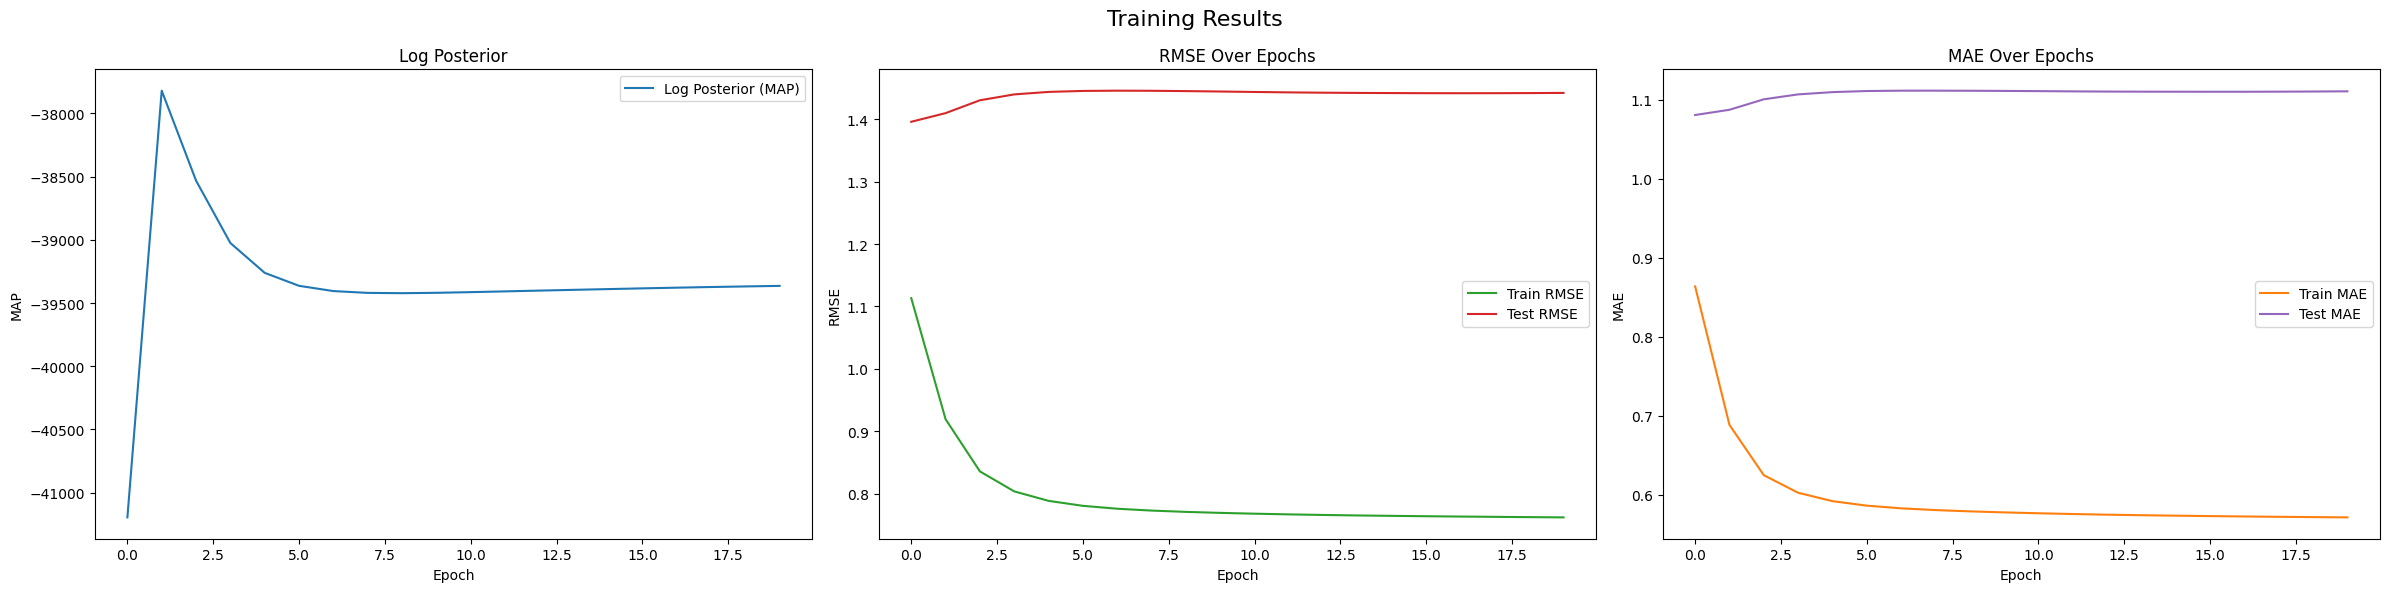

In [8]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
plt.suptitle('Training Results', fontsize=16)

# Log Posterior (MAP)
ax1.plot(np.arange(len(log_ps)), log_ps, label='Log Posterior (MAP)', color='tab:blue')
ax1.set_title('Log Posterior')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAP')
ax1.legend()

# RMSE Plot
ax2.plot(np.arange(len(rmse_train)), rmse_train, label='Train RMSE', color='tab:green')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='Test RMSE', color='tab:red')
ax2.set_title('RMSE Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.legend()

# MAE Plot
ax3.plot(np.arange(len(mae_train)), mae_train, label='Train MAE', color='tab:orange')
ax3.plot(np.arange(len(mae_test)), mae_test, label='Test MAE', color='tab:purple')
ax3.set_title('MAE Over Epochs')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('MAE')
ax3.legend()

plt.tight_layout()
plt.show()

In [9]:
print('RMSE of training set:', pmf_model.evaluate(train_set))
print('RMSE of testing set:', pmf_model.evaluate(test_set))

RMSE of training set: (0.7619508319281216, 0.5711918293868347)
RMSE of testing set: (1.4423715473571361, 1.1109541564142398)


In [10]:
lda_recommender = lda_model(n_topics=15, max_iter=20)

In [11]:
# Define parameter grid for tuning
param_grid = {
    'n_topics': [15],
    'alpha': [0.01],
    'beta': [0.5],
    'reg_lambda': [0.5]
}

print("finding best parameters")
best_params = lda_recommender.find_best_params(lda_train_set, param_grid)
print("Best parameters found:", best_params)


finding best parameters
in train, vectorizing anime dataset
building user topic profiles
in train, vectorizing anime dataset
building user topic profiles
in train, vectorizing anime dataset
building user topic profiles
Parameters: n_topics=15, alpha=0.01, beta=0.5, reg_lambda=0.5, RMSE=1.3788
Best parameters found: {'n_topics': 15, 'alpha': 0.01, 'beta': 0.5, 'reg_lambda': 0.5}


In [12]:
lda_recommender = lda_model(
    n_topics=best_params['n_topics'],
    max_iter=10,
    alpha=best_params['alpha'],
    beta=best_params['beta'],
    reg_lambda=best_params['reg_lambda']
)

In [13]:
lda_recommender.train(train_set=lda_train_set, test_set=lda_test_set)

in train, vectorizing anime dataset
building user topic profiles


In [14]:
lda_rmse_train, lda_mae_train = lda_recommender.evaluate(lda_train_set)
lda_rmse_test, lda_mae_test = lda_recommender.evaluate(lda_test_set)
print('RMSE Train:', lda_rmse_train)
print('RMSE Test:', lda_rmse_test)
print('MAE Train:', lda_mae_train)
print('MAE Test:', lda_mae_test)

RMSE Train: 0.8363253352485328
RMSE Test: 1.4732985743823972
MAE Train: 0.6100649194793437
MAE Test: 1.1373477937635719


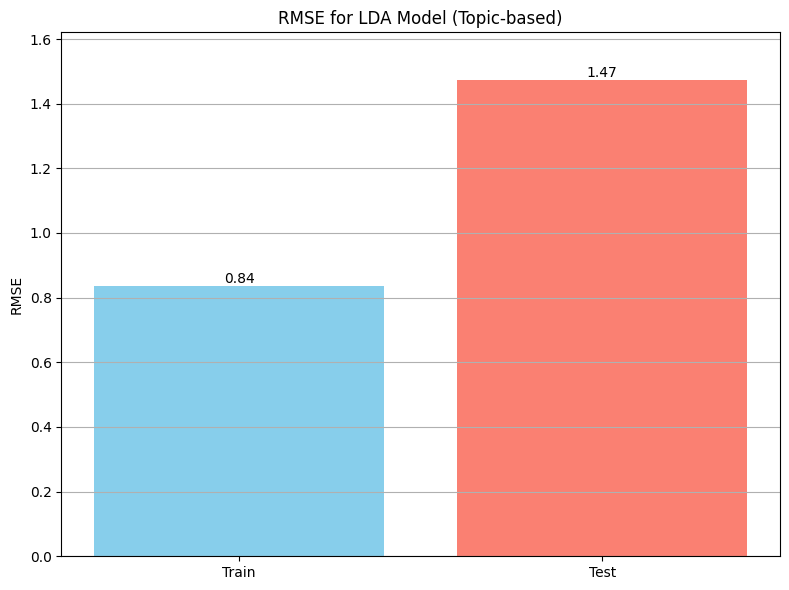

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
x = ['Train', 'Test']
y = [lda_rmse_train, lda_rmse_test]
bars = ax.bar(x, y, color=['skyblue', 'salmon'])
ax.set_ylim(0, max(y) * 1.1)
ax.set_title("RMSE for LDA Model (Topic-based)")
ax.set_ylabel("RMSE")
ax.bar_label(bars, fmt='%.2f')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [16]:
topic_counts = [5, 10, 20, 30, 40]
train_rmse_list = []
test_rmse_list = []
test_mae_list = []
train_mae_list = []

for n in topic_counts:
    model = lda_model(n_topics=n, max_iter=100)
    model.train(lda_train_set, lda_test_set)
    temp_train_rmse, temp_train_mae = model.evaluate(lda_train_set)
    temp_test_rmse, temp_test_mae = model.evaluate(lda_test_set)
    train_rmse_list.append(temp_train_rmse)
    test_rmse_list.append(temp_test_rmse)
    train_mae_list.append(temp_train_mae)
    test_mae_list.append(temp_test_mae)

in train, vectorizing anime dataset
building user topic profiles
in train, vectorizing anime dataset
building user topic profiles
in train, vectorizing anime dataset
building user topic profiles
in train, vectorizing anime dataset
building user topic profiles
in train, vectorizing anime dataset
building user topic profiles


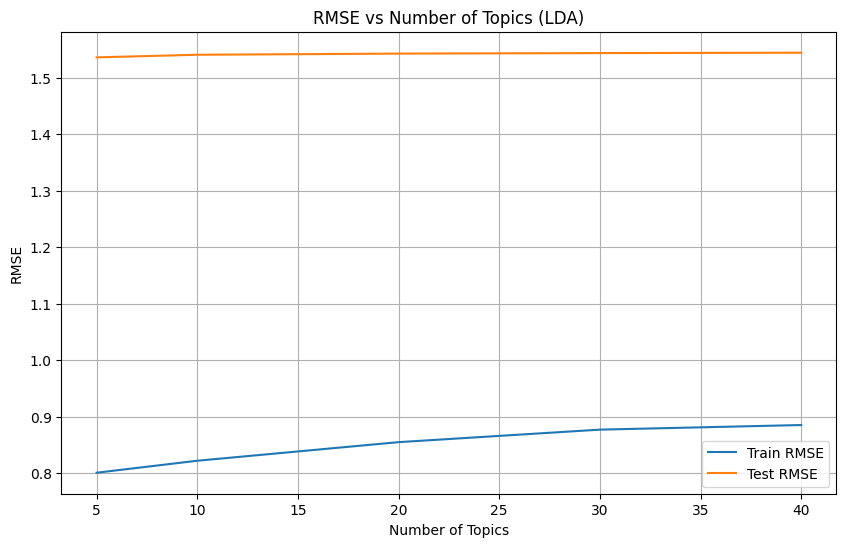

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(topic_counts, train_rmse_list, label='Train RMSE')
plt.plot(topic_counts, test_rmse_list, label='Test RMSE')
plt.xlabel('Number of Topics')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Topics (LDA)')
plt.legend()
plt.grid(True)
plt.show()

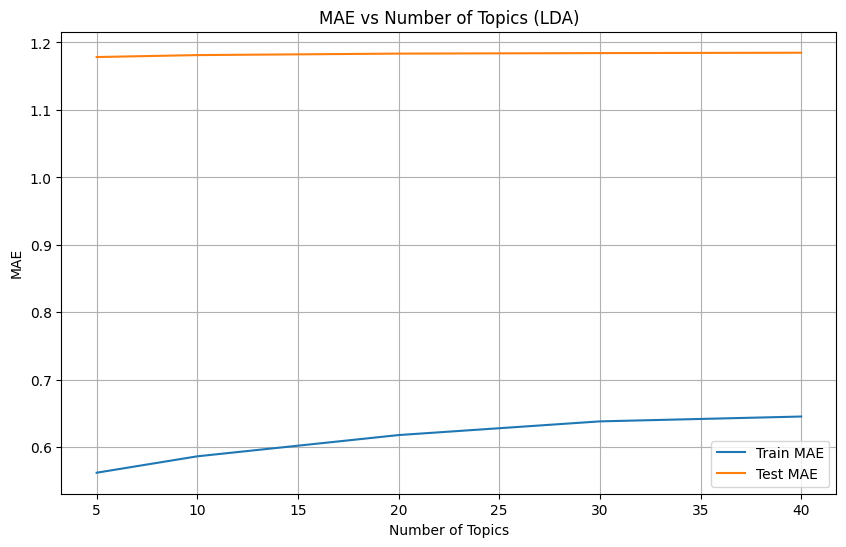

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(topic_counts, train_mae_list, label='Train MAE')
plt.plot(topic_counts, test_mae_list, label='Test MAE')
plt.xlabel('Number of Topics')
plt.ylabel('MAE')
plt.title('MAE vs Number of Topics (LDA)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from modern_pmf import opt_pmf
opt_pmf_model = opt_pmf(n_users=n_users, n_animes=n_animes, lambda_U=10, lambda_V=10, uniq_users=uniq_users, uniq_animes=uniq_animes, n_dimesions=5)
log_ps_opt, rmse_train_opt, rmse_test_opt, mae_train_opt, mae_test_opt = opt_pmf_model.train(train_set=train_set, test_set=test_set, n_epochs=20)

Epoch 1: Train RMSE = 6.6653, Test RMSE = 6.6922
Epoch 10: Train RMSE = 1.9682, Test RMSE = 4.5488
Epoch 20: Train RMSE = 0.8265, Test RMSE = 4.1210


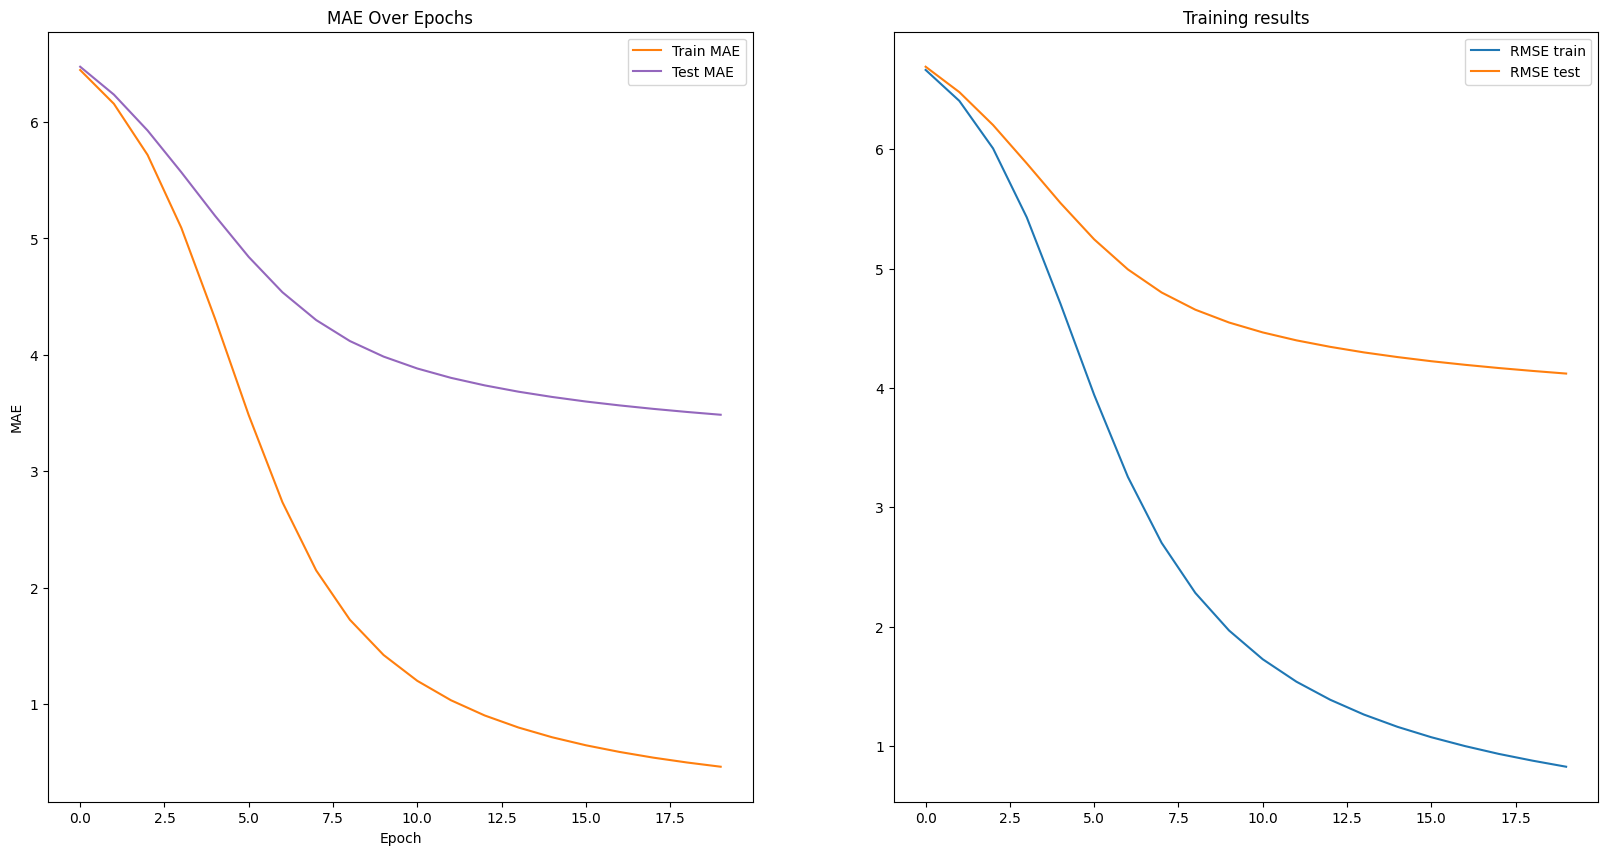

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(mae_train_opt)), mae_train_opt, label='Train MAE', color='tab:orange')
ax1.plot(np.arange(len(mae_test_opt)), mae_test_opt, label='Test MAE', color='tab:purple')
ax1.set_title('MAE Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAE')
ax1.legend()

ax2.plot(np.arange(len(rmse_train_opt)), rmse_train_opt, label='RMSE train')
ax2.plot(np.arange(len(rmse_test_opt)), rmse_test_opt, label='RMSE test')
ax2.legend()

plt.show()